In [1]:
import os

# Limit the number of threads for various libraries
os.environ["MKL_NUM_THREADS"] = "12"  # For MKL (used by NumPy)
os.environ["NUMEXPR_NUM_THREADS"] = "12"  # For NumExpr
os.environ["VECLIB_MAXIMUM_THREADS"] = "12"  # For macOS Accelerate
os.environ["OPENBLAS_NUM_THREADS"] = "12"  # For OpenBLAS
os.environ["BLIS_NUM_THREADS"] = "12"  # For BLIS

# Print environment variables to verify
print("OMP_NUM_THREADS:", os.environ.get("OMP_NUM_THREADS"))
print("MKL_NUM_THREADS:", os.environ.get("MKL_NUM_THREADS"))
print("NUMEXPR_NUM_THREADS:", os.environ.get("NUMEXPR_NUM_THREADS"))
print("VECLIB_MAXIMUM_THREADS:", os.environ.get("VECLIB_MAXIMUM_THREADS"))
print("OPENBLAS_NUM_THREADS:", os.environ.get("OPENBLAS_NUM_THREADS"))
print("BLIS_NUM_THREADS:", os.environ.get("BLIS_NUM_THREADS"))

# Set PyTorch threads
import torch
torch.set_num_threads(18)
torch.set_num_interop_threads(18)

OMP_NUM_THREADS: None
MKL_NUM_THREADS: 12
NUMEXPR_NUM_THREADS: 12
VECLIB_MAXIMUM_THREADS: 12
OPENBLAS_NUM_THREADS: 12
BLIS_NUM_THREADS: 12


In [2]:
%cd ../..

/data/users/rodalex/RepClassifier


In [3]:
# WrappedRepresentationDataset & PCAExplainability - Usage Demo
# ======================================================
# This notebook demonstrates how to use WrappedRepresentationDataset and PCAExplainability
# to perform dimensionality reduction and interpret protein embedding data.

from project_root.dataset.dataset_loader import DatasetLoader
from project_root.dataset.representation_dataset import RepresentationDataset
from project_root.dataset.wrapped_representation_dataset import WrappedRepresentationDataset
from project_root.utils.visualization import DataVisualizer

from torch.utils.data import DataLoader, TensorDataset

from project_root.models.protein_classifier import ProteinClassifier
from project_root.training.trainer import Trainer

# ------------------------------------------------------
# 📥 1. Load Dataset and Embeddings
# ------------------------------------------------------

# Define data path
path_dataset_folder = "../DATASETS/"

# Load data
loader = DatasetLoader(path_dataset_folder)
df = loader.load_dataframe()
embeddings, attention_weights = loader.load_embeddings_and_attention()

# Create RepresentationDataset instance
representation_dataset = RepresentationDataset(df, embeddings, attention_weights, solve_inconsistencies=True)

/data/users/rodalex/software/miniconda3/envs/prot_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Checking consistency...
Removing duplicate entries...
Resolving inconsistencies. Keeping 1219 common samples.
Consistency checked.

ProteinDataset Report:
 - Number of samples: 1219
 - Number of embeddings: 1219
 - Number of attention weights: 1219
 - Target column: Class
 - ID column: UniProt IDs
 - Save path: ./OUTPUTS/



In [6]:
# Check atributtes
print("Dataset attributes:")
print(representation_dataset.dataframe.columns)
print(representation_dataset.dataframe.head())

Dataset attributes:
Index(['UniProt IDs', 'PDB ID', 'Gene Name', 'Protein Name',
       'Amino Acid Sequence', 'Organism Name', 'Status', 'Protein Existence',
       'GO BP Terms', 'GO CC Terms', 'GO MF Terms', 'Max_MBL_CC',
       'CC_Pairs_Max_MBL', 'Max_MBL_MF', 'MF_Pairs_Max_MBL', 'Highest_MBL',
       'Class'],
      dtype='object')
  UniProt IDs                                             PDB ID  \
1      Q9Y2X8                                                NaN   
2      Q05086  1C4Z; 1D5F; 1EQX; 2KR1; 4GIZ; 4XR8; 6SJV; 6SLM...   
3      Q9Y6X0                                                NaN   
4      Q8BH75                                               2OGB   
5      Q04120                                   5DVB; 5EPT; 6UTL   

                                           Gene Name  \
1         {'Name': 'UBE2D4', 'Synonyms': ['UBCH5D']}   
2  {'Name': 'UBE3A {ECO:0000312|HGNC:HGNC:12496}'...   
3       {'Name': 'SETBP1', 'Synonyms': ['KIAA0437']}   
4   {'Name': 'Rnf41', 'Syno

In [8]:
# Print number of protins with Protein Existence diferent from 1
print("Number of proteins with Protein Existence different from 1:", len(representation_dataset.dataframe[representation_dataset.dataframe["Protein Existence"] != 1.]))

# Print unic values of GO BP Terms, GO CC Terms, GO MF Terms
print("Number of unique values of GO BP Terms:")
print(len(representation_dataset.dataframe["GO BP Terms"].unique()))
print("Number of unique values of GO CC Terms:")
print(len(representation_dataset.dataframe["GO CC Terms"].unique()))
print("Number of unique values of GO MF Terms:")
print(len(representation_dataset.dataframe["GO MF Terms"].unique()))


Number of proteins with Protein Existence different from 1: 31
Number of unique values of GO BP Terms:
1171
Number of unique values of GO CC Terms:
1012
Number of unique values of GO MF Terms:
1088


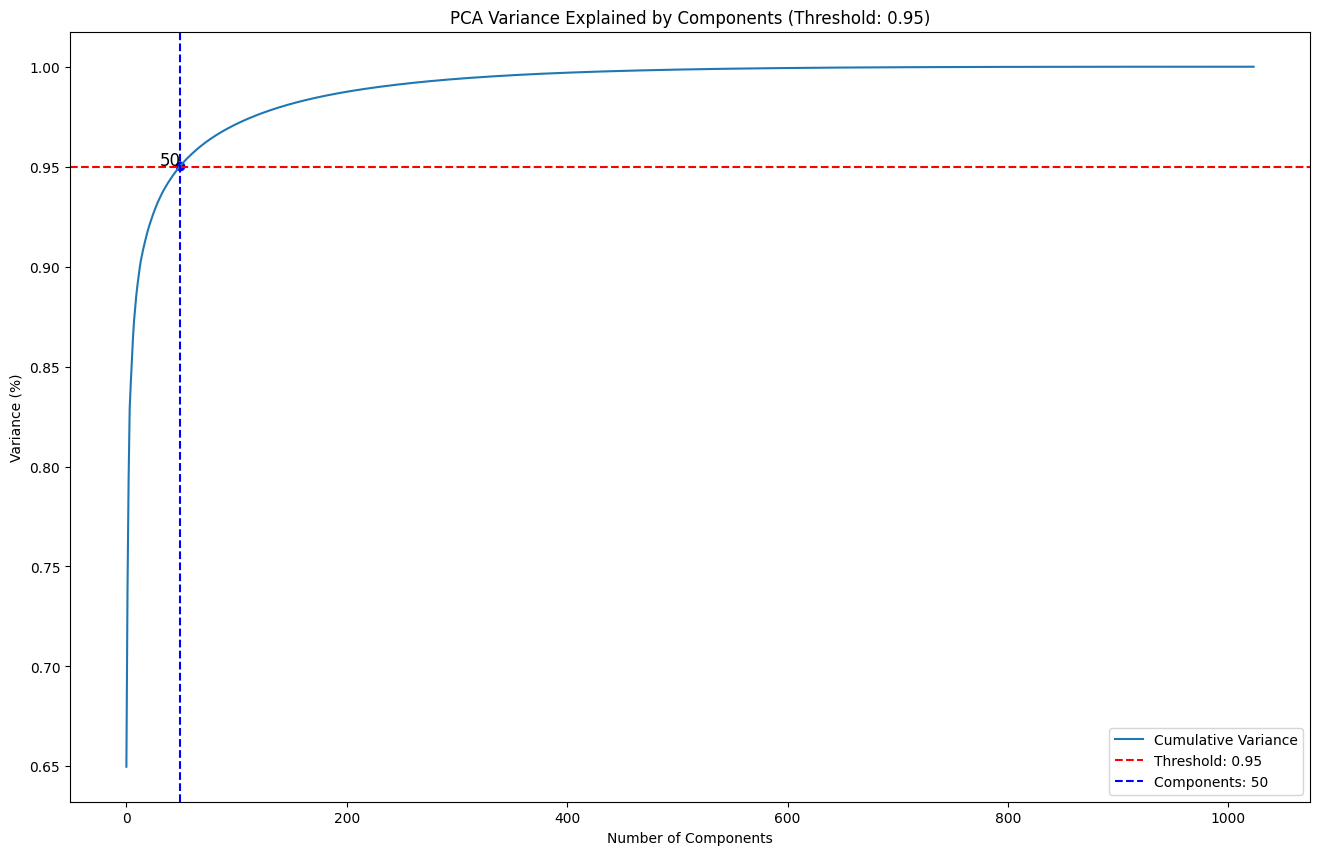

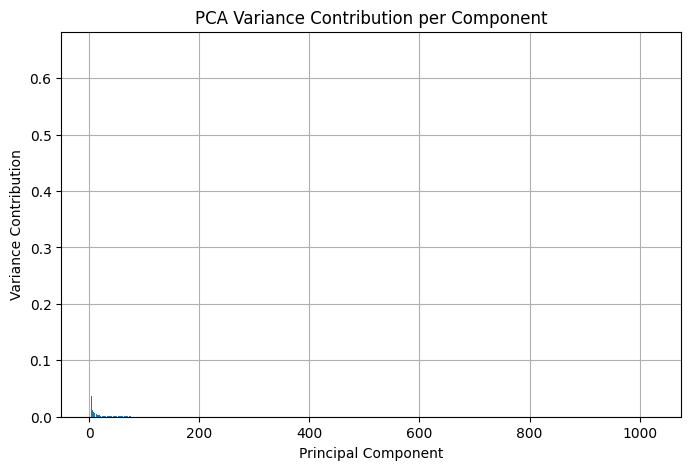

In [4]:
from sklearn.decomposition import PCA

# Apply PCA to the embeddings
original_embeddings = representation_dataset.get_embeddings()

# Create the PCA object
n_components = min(len(original_embeddings), len(original_embeddings[0]))
pca = PCA(n_components=n_components)

# Fit the PCA object and transform the data
original_embeddings_pca = pca.fit_transform(original_embeddings)

# Data Visualizer
DataVisualizer.plot_variance_explained(pca)  # Pass the PCA object
DataVisualizer.plot_variance_contribution(pca)  # Pass the PCA object

In [10]:
# ------------------------------------------------------
# 🧪 2. Create WrappedRepresentationDataset with Configurations
# ------------------------------------------------------

wrapped_dataset = WrappedRepresentationDataset(
    dataset=representation_dataset,
    process_attention_weights=False,
    reduce_method='pca',              # or 'tsne'
    pca_method='threshold',           # 'threshold', 'derivative', 'custom'
    threshold=0.95,
    random_projection_dim=50        # Random projection dim before PCA on attention weights
)

Converting embeddings and attention weights to NumPy arrays...
Applying dimensionality reduction using pca...


Adding labels to data...
Shape data before adding: (1219, 50) | Shape labels: (1219, 1)
Adding additional columns to data...
Shape data before adding: (1219, 51) | Shape column: (1219, 1)
Shape data before adding: (1219, 52) | Shape column: (1219, 1)
Shape data before adding: (1219, 53) | Shape column: (1219, 1)
Final data shape: (1219, 54)
Column order in the resulting dataset:
Column 0: target_column
Column 1: Max_MBL_CC
Column 2: Max_MBL_MF
Column 3: Highest_MBL


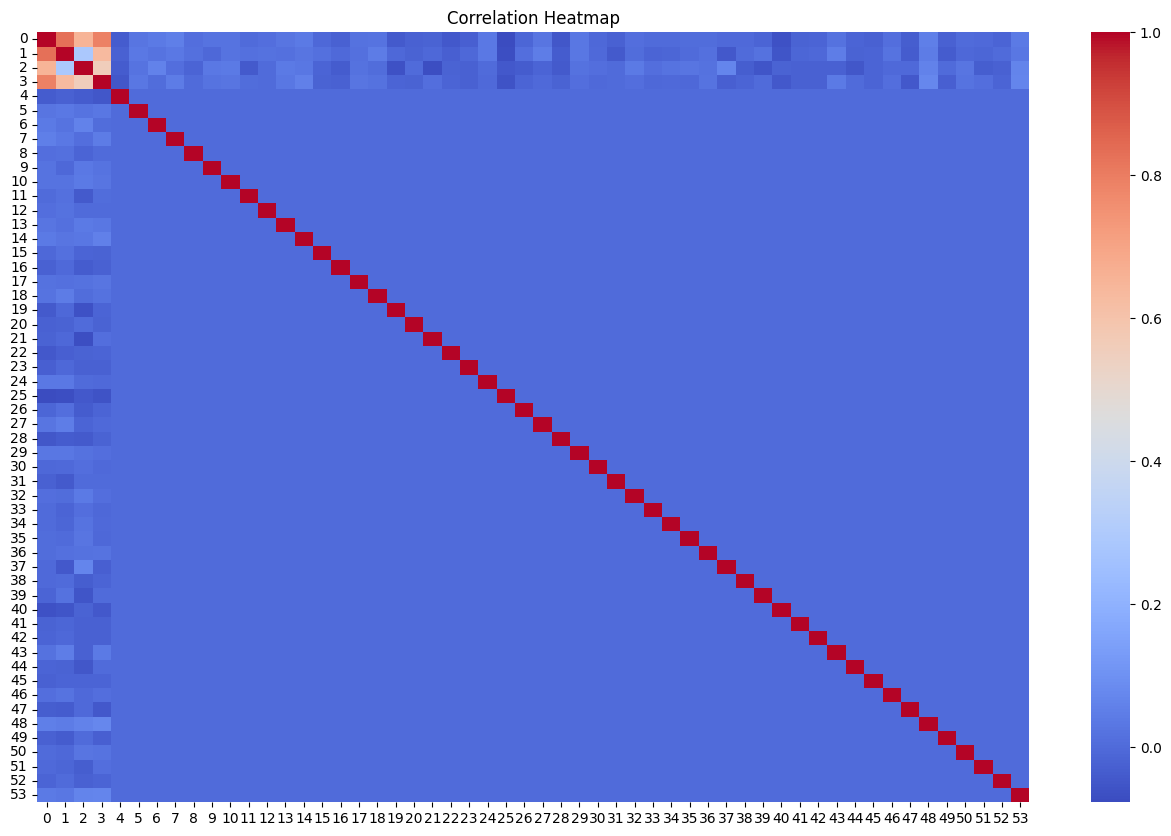

In [7]:
# Concatenate the data with the target column
data_emb_target = wrapped_dataset.select_data(embedding = True,
                                   attention_weights = False,
                                   target_column = True,
                                   additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                   )

DataVisualizer.plot_correration_heatmap(data_emb_target)

In [ ]:
DataVisualizer.plot_correration_heatmap(data_comb)

In [ ]:
DataVisualizer.plot_correration_heatmap(data_att)

In [ ]:
DataVisualizer.plot_correration_heatmap(data_emb)

In [15]:

def train_model(data, num_epochs=200, seed=2025):

    # Set random seed for reproducibility
    torch.manual_seed(seed)

    # -----------------------------------------
    # 🧪 Prepare dataloaders
    # -----------------------------------------
    X = torch.tensor(data, dtype=torch.float32)
    y = torch.tensor(representation_dataset.get_labels(), dtype=torch.float32)

    dataset = TensorDataset(X, y)
    split = int(0.6 * len(dataset))
    train_dataset, test_dataset = torch.utils.data.random_split(dataset, [split, len(dataset) - split])

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16)

    # -----------------------------------------
    # 🧠 Build and train model
    # -----------------------------------------
    input_size = X.shape[1]
    model_fn = lambda size: ProteinClassifier(
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        input_size=input_size,
        output_size=1,
        num_hidden_layers=1,
        hidden_layers_mode='quadratic_increase'
    )

    trainer = Trainer(model_class=model_fn)
    train_losses, val_losses, train_accs, val_accs = trainer.train_and_validate(train_loader, test_loader, num_epochs=num_epochs)

    # -----------------------------------------
    # 📈 Visualize results and evaluate
    # -----------------------------------------
    trainer.plot_results(train_losses, val_losses, train_accs, val_accs)
    trainer.evaluate_and_plot_confusion_matrix(test_loader)

    print("✅ ProteinClassifier + Trainer test complete")

    return trainer, train_dataset, test_dataset


In [13]:
data_emb = wrapped_dataset.select_data(embedding = True,
                                   attention_weights = False)

data_emb_mbl = wrapped_dataset.select_data(embedding = True,
                                      attention_weights = False,
                                      additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                      )

Final data shape: (1219, 50)
Column order in the resulting dataset:
Adding additional columns to data...
Shape data before adding: (1219, 50) | Shape column: (1219, 1)
Shape data before adding: (1219, 51) | Shape column: (1219, 1)
Shape data before adding: (1219, 52) | Shape column: (1219, 1)
Final data shape: (1219, 53)
Column order in the resulting dataset:
Column 0: Max_MBL_CC
Column 1: Max_MBL_MF
Column 2: Highest_MBL


In [ ]:
data_comb = wrapped_dataset.select_data(embedding = True, 
                                   attention_weights = True, 
                                   additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                   )

data_att = wrapped_dataset.select_data(embedding = False,
                                      attention_weights = True,
                                      additional_columns = ['Max_MBL_CC', 'Max_MBL_MF', 'Highest_MBL']
                                      )

Layer (type:depth-idx)                   Output Shape              Param #
ProteinClassifier                        [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 25]                   1,275
│    └─ReLU: 2-2                         [1, 25]                   --
│    └─Dropout: 2-3                      [1, 25]                   --
│    └─Linear: 2-4                       [1, 1]                    26
Total params: 1,301
Trainable params: 1,301
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
Epoch 1, Training Loss: 0.6999, Validation Loss: 0.6960, Training Accuracy: 0.4637, Validation Accuracy: 0.4734
Epoch 2, Training Loss: 0.6995, Validation Loss: 0.6957, Training Accuracy: 0.4569, Validation Accuracy: 0.4959
Epoch 3, Training Loss: 0.6994, Validation Loss: 0.6954, Training Acc

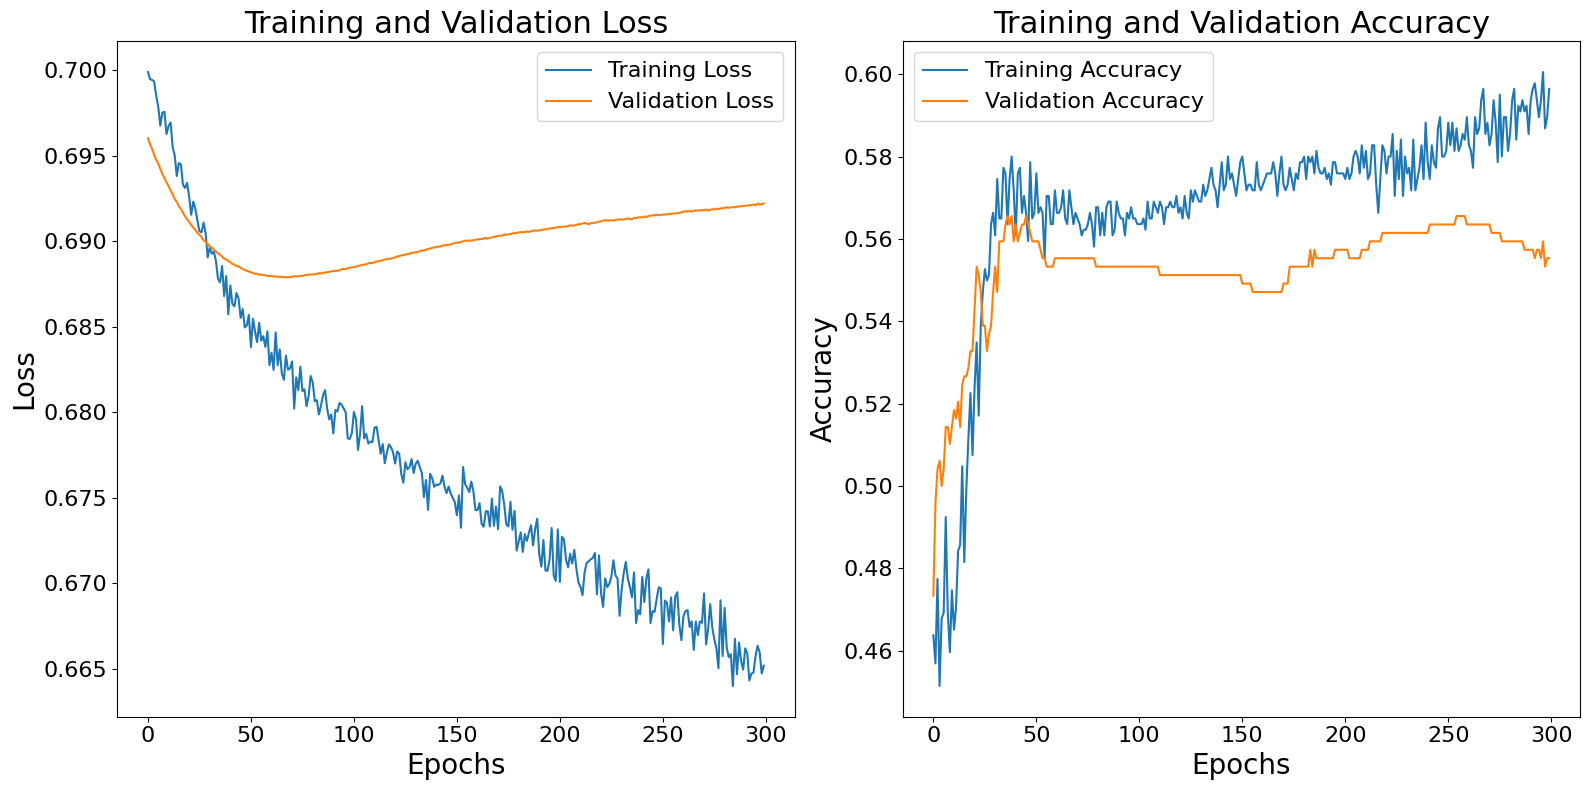

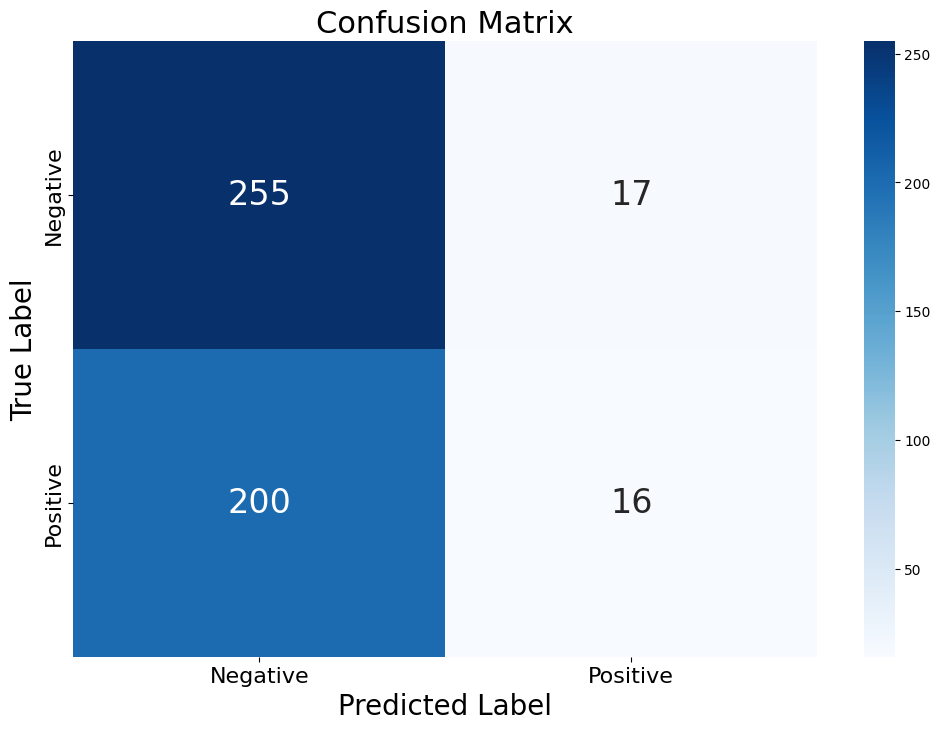


Métricas de Evaluación:
              precision    recall  f1-score   support

    Negative       0.56      0.94      0.70       272
    Positive       0.48      0.07      0.13       216

    accuracy                           0.56       488
   macro avg       0.52      0.51      0.42       488
weighted avg       0.53      0.56      0.45       488

Especificidad: 0.9375
Estadístico Kappa: 0.0127
✅ ProteinClassifier + Trainer test complete


In [16]:
trainer, train_dataset, test_dataset = train_model(data_emb, num_epochs=300)

Layer (type:depth-idx)                   Output Shape              Param #
ProteinClassifier                        [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 26]                   1,404
│    └─ReLU: 2-2                         [1, 26]                   --
│    └─Dropout: 2-3                      [1, 26]                   --
│    └─Linear: 2-4                       [1, 1]                    27
Total params: 1,431
Trainable params: 1,431
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
Epoch 1, Training Loss: 0.7951, Validation Loss: 0.7859, Training Accuracy: 0.2914, Validation Accuracy: 0.2480
Epoch 2, Training Loss: 0.7782, Validation Loss: 0.7694, Training Accuracy: 0.2709, Validation Accuracy: 0.2480
Epoch 3, Training Loss: 0.7671, Validation Loss: 0.7541, Training Acc

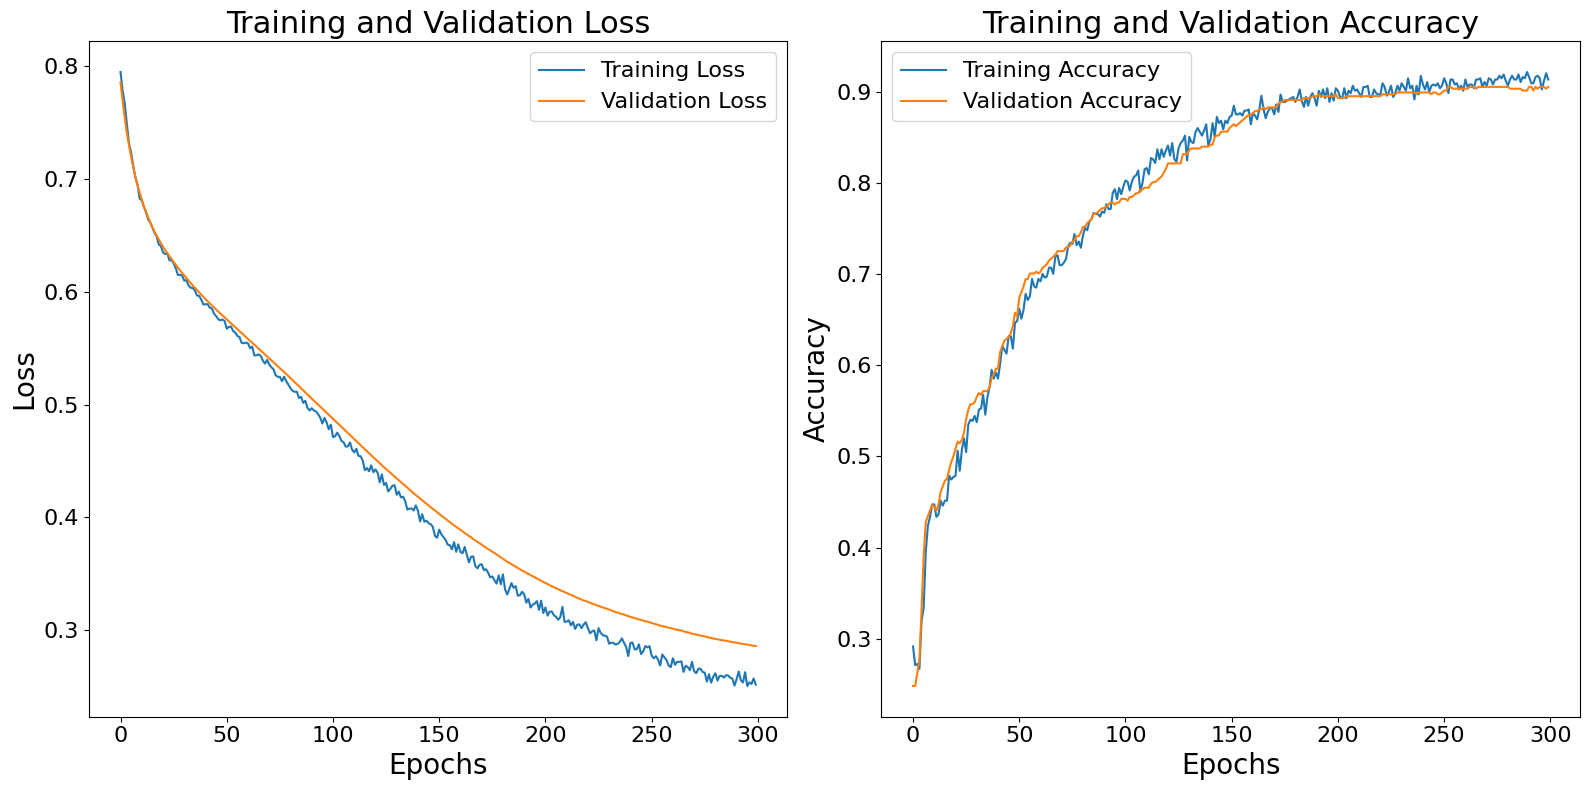

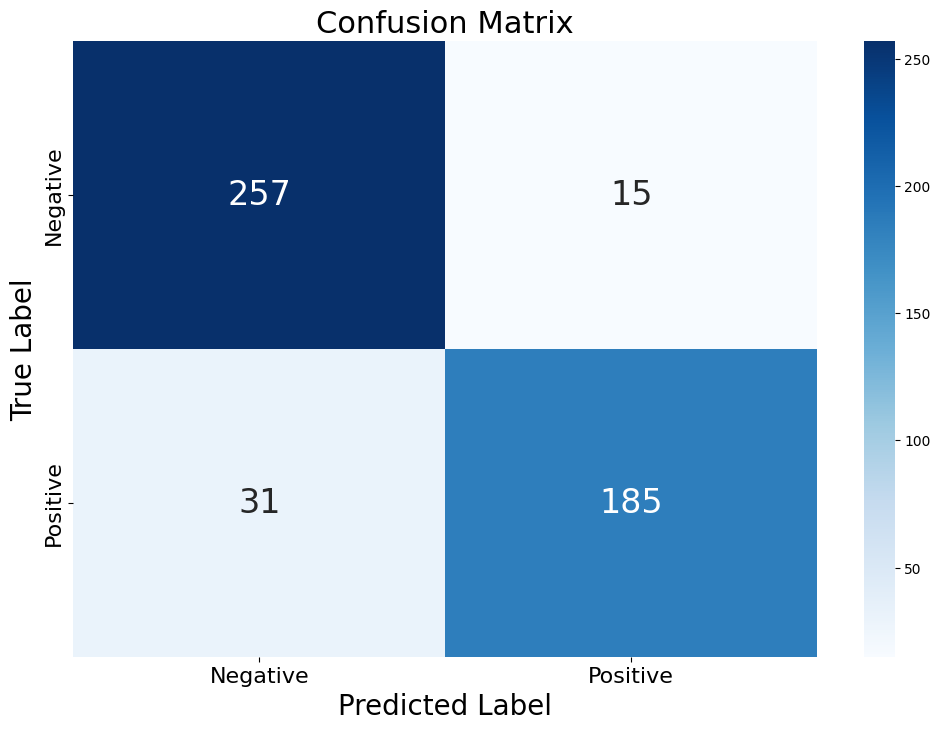


Métricas de Evaluación:
              precision    recall  f1-score   support

    Negative       0.89      0.94      0.92       272
    Positive       0.93      0.86      0.89       216

    accuracy                           0.91       488
   macro avg       0.91      0.90      0.90       488
weighted avg       0.91      0.91      0.91       488

Especificidad: 0.9449
Estadístico Kappa: 0.8075
✅ ProteinClassifier + Trainer test complete


In [17]:
trainer, train_dataset, test_dataset = train_model(data_emb_mbl, num_epochs=300)

Layer (type:depth-idx)                   Output Shape              Param #
ProteinClassifier                        [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 24]                   1,200
│    └─ReLU: 2-2                         [1, 24]                   --
│    └─Dropout: 2-3                      [1, 24]                   --
│    └─Linear: 2-4                       [1, 1]                    25
Total params: 1,225
Trainable params: 1,225
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.01
Epoch 1, Training Loss: 0.8440, Validation Loss: 0.8238, Training Accuracy: 0.5116, Validation Accuracy: 0.5061
Epoch 2, Training Loss: 0.8311, Validation Loss: 0.8060, Training Accuracy: 0.5144, Validation Accuracy: 0.5000
Epoch 3, Training Loss: 0.8073, Validation Loss: 0.7890, Training Acc

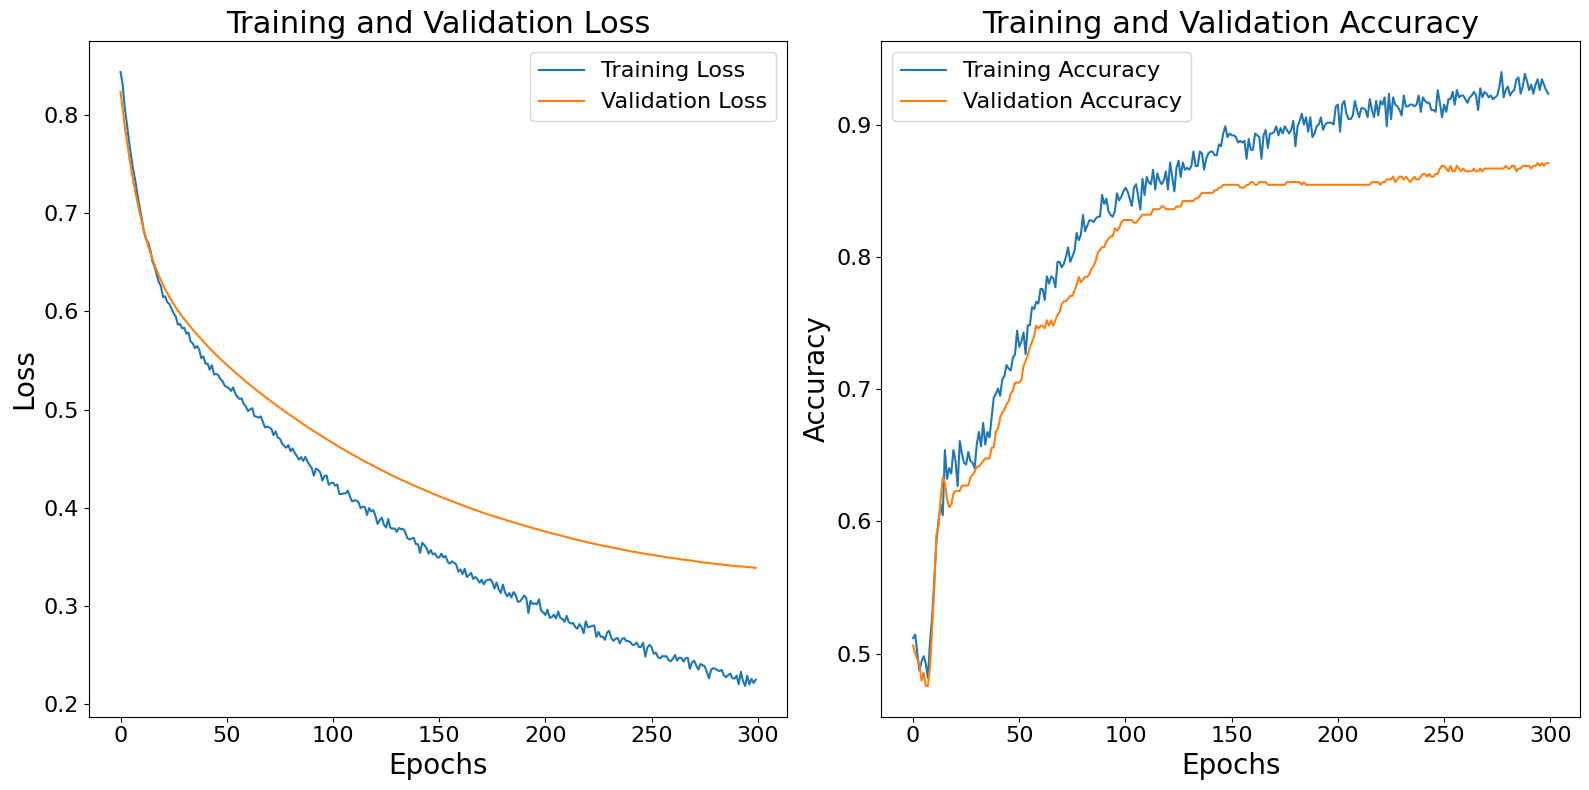

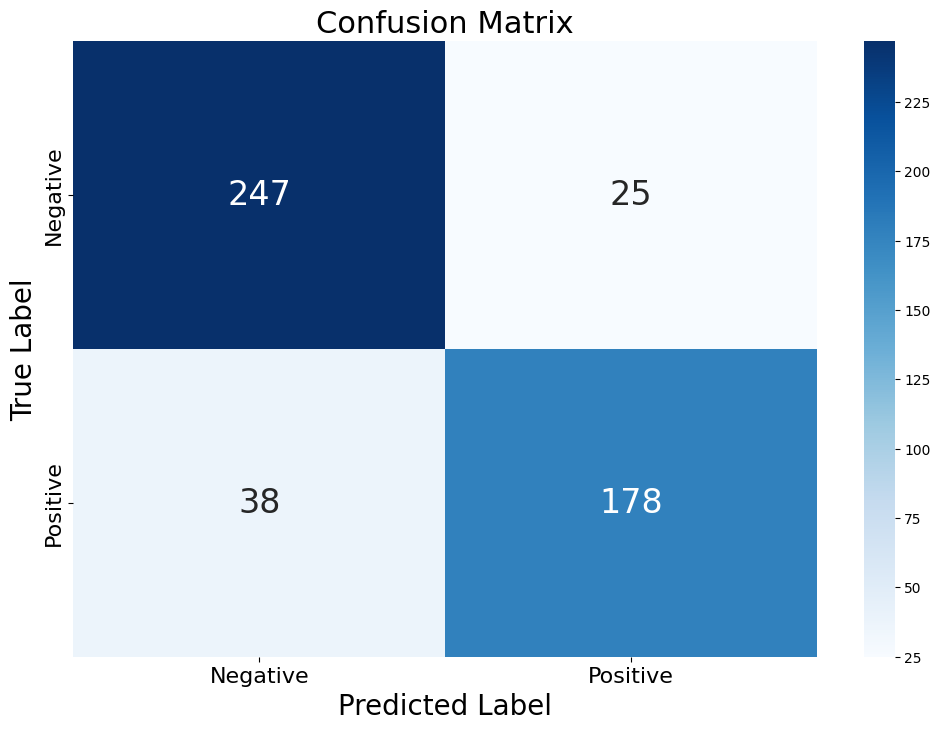


Métricas de Evaluación:
              precision    recall  f1-score   support

    Negative       0.87      0.91      0.89       272
    Positive       0.88      0.82      0.85       216

    accuracy                           0.87       488
   macro avg       0.87      0.87      0.87       488
weighted avg       0.87      0.87      0.87       488

Especificidad: 0.9081
Estadístico Kappa: 0.7367
✅ ProteinClassifier + Trainer test complete


In [16]:
train_model(data_att, num_epochs=300)

Layer (type:depth-idx)                   Output Shape              Param #
ProteinClassifier                        [1, 1]                    --
├─Sequential: 1-1                        [1, 1]                    --
│    └─Linear: 2-1                       [1, 49]                   4,900
│    └─ReLU: 2-2                         [1, 49]                   --
│    └─Dropout: 2-3                      [1, 49]                   --
│    └─Linear: 2-4                       [1, 1]                    50
Total params: 4,950
Trainable params: 4,950
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.02
Estimated Total Size (MB): 0.02
Epoch 1, Training Loss: 0.7704, Validation Loss: 0.7497, Training Accuracy: 0.4610, Validation Accuracy: 0.4898
Epoch 2, Training Loss: 0.7526, Validation Loss: 0.7329, Training Accuracy: 0.4583, Validation Accuracy: 0.4795
Epoch 3, Training Loss: 0.7372, Validation Loss: 0.7190, Training Acc

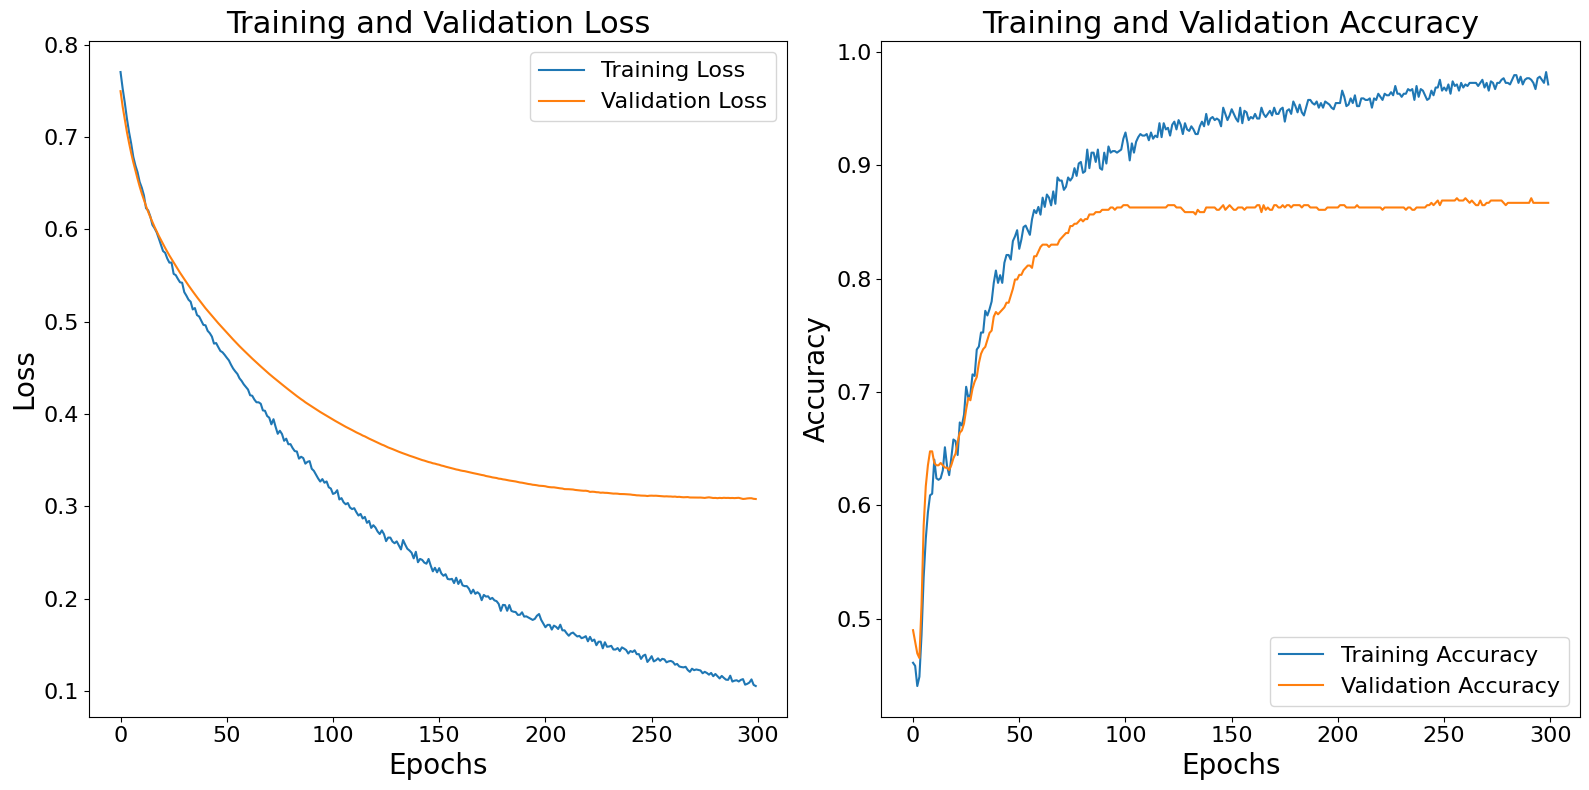

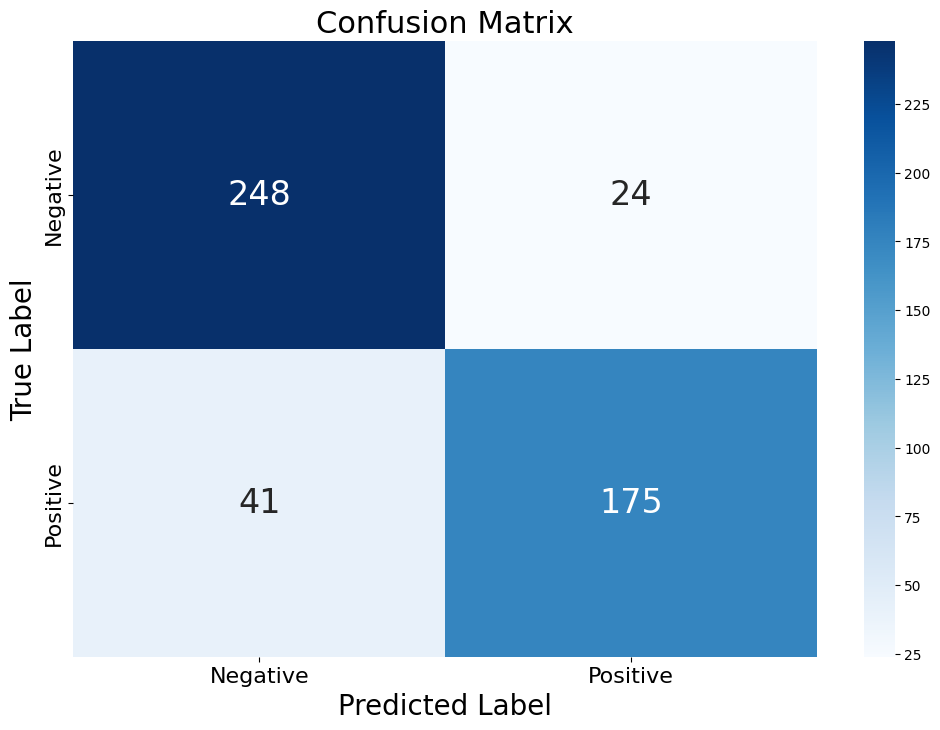


Métricas de Evaluación:
              precision    recall  f1-score   support

    Negative       0.86      0.91      0.88       272
    Positive       0.88      0.81      0.84       216

    accuracy                           0.87       488
   macro avg       0.87      0.86      0.86       488
weighted avg       0.87      0.87      0.87       488

Especificidad: 0.9118
Estadístico Kappa: 0.7278
✅ ProteinClassifier + Trainer test complete


In [17]:
train_model(data_comb, num_epochs=300)